In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

import numpy as np
import sys
import matplotlib.pyplot as plt
# %matplotlib inline
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, normalize

from stardist.matching import matching_dataset
from stardist import fill_label_holes, random_label_cmap, relabel_image_stardist, calculate_extents, gputools_available, _draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Prepare the Dataset

In [2]:
def read_tif(input_path):
    image = imread(input_path)
    if len(image.shape) == 3:
        image = image.mean(axis=-1).astype(np.uint8)
        
    return image

In [3]:
DATASET_DIR = '../S-BSST265/'
DATASET_LIST = 'train.txt'
image_dir = os.path.join(DATASET_DIR, 'rawimages')
mask_dir = os.path.join(DATASET_DIR, 'groundtruth')

data_lines = open(os.path.join(DATASET_DIR, DATASET_LIST), 'r').readlines()
imagelist = list(map(lambda x: os.path.join(image_dir, x.strip()), data_lines))
masklist = list(map(lambda x: os.path.join(mask_dir, x.strip()), data_lines))

In [4]:
imagelist

['../S-BSST265/rawimages/Ganglioneuroblastoma_1.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_10.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_2.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_3.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_4.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_6.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_7.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_8.tif',
 '../S-BSST265/rawimages/Neuroblastoma_0.tif',
 '../S-BSST265/rawimages/Neuroblastoma_1.tif',
 '../S-BSST265/rawimages/Neuroblastoma_10.tif',
 '../S-BSST265/rawimages/Neuroblastoma_11.tif',
 '../S-BSST265/rawimages/Neuroblastoma_12.tif',
 '../S-BSST265/rawimages/Neuroblastoma_13.tif',
 '../S-BSST265/rawimages/Neuroblastoma_14.tif',
 '../S-BSST265/rawimages/Neuroblastoma_15.tif',
 '../S-BSST265/rawimages/Neuroblastoma_16.tif',
 '../S-BSST265/rawimages/Neuroblastoma_17.tif',
 '../S-BSST265/rawimages/Neuroblastoma_3.tif',
 '../S-BSST265/rawimages/Neuroblastoma_4.t

In [5]:
fX = imagelist
fY = masklist

In [6]:
fX_small, fY_small = fX[:10], fY[:10]

X_small = list(map(read_tif,map(str,fX_small)))
Y_small = list(map(read_tif,map(str,fY_small)))

# Example Image

In [7]:
i = min(4, len(X_small)-1)
img, lbl = X_small[i], fill_label_holes(Y_small[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

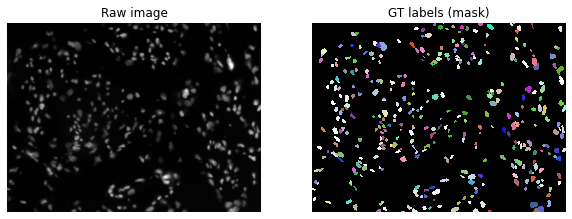

In [8]:
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
None;

# Fit Example Image with Star-Convex Polygons

In [9]:
n_rays = [2**i for i in range(2,8)]
print(n_rays)

[4, 8, 16, 32, 64, 128]


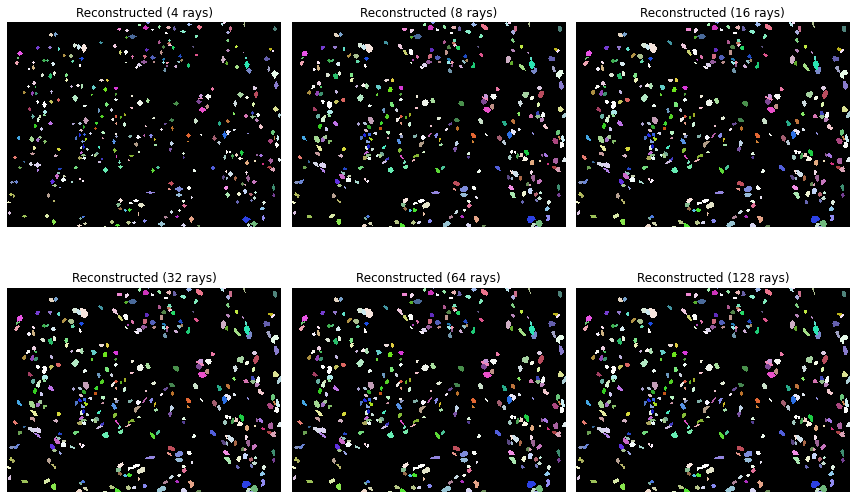

In [10]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap, interpolation="nearest")
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

In [11]:
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y_small]
    mean_iou = matching_dataset(Y_small, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [01:23<00:00, 13.92s/it]


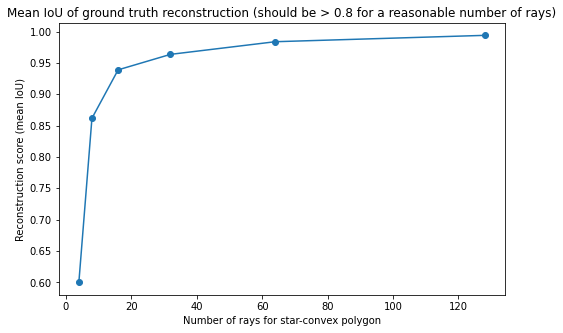

In [12]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean IoU)')
plt.title("Mean IoU of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

# Training

In [13]:
X = list(map(read_tif,map(str,tqdm(fX))))
Y = list(map(read_tif,map(str,tqdm(fY))))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

100%|██████████| 70/70 [00:00<00:00, 140.83it/s]


In [14]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 70/70 [00:01<00:00, 46.16it/s]


In [15]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  70
- training:        60
- validation:      10


## Check for Mismatching Sample Pairs

In [16]:
# Remove Mismatches

mismatch_indices = []
for i in range(len(X_trn)):
    if X_trn[i].shape != Y_trn[i].shape:
        mismatch_indices.append(i)
        print('Removed mismatch %d' % i)
        
for i in mismatch_indices:
    X_trn.pop(i)
    Y_trn.pop(i)
    
    
mismatch_indices = []
for i in range(len(X_val)):
    if X_val[i].shape != Y_val[i].shape:
        mismatch_indices.append(i)
        print('Removed mismatch %d' % i)
        
for i in mismatch_indices:
    X_val.pop(i)
    Y_val.pop(i)

Removed mismatch 42


In [17]:
for i in range(len(X_trn)):
    if X_trn[i].shape != Y_trn[i].shape:
        print('Found mismatch %d' % i)
        
for i in range(len(X_val)):
    if X_val[i].shape != Y_val[i].shape:
        mismatch_indices.append(i)
        print('Found mismatch %d' % i)

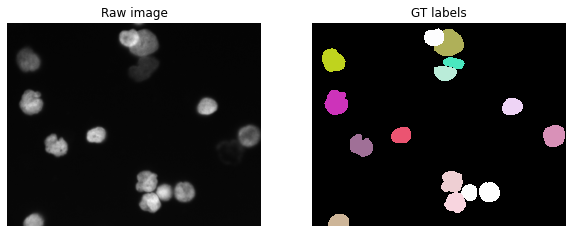

In [18]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels')
None;

# Configuration

In [19]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [20]:
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    n_channel_in = 1,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [21]:
model = StarDist2D(conf, name='stardist', basedir='models')

/cvlabdata2/home/beker/miniconda3/envs/stardist/lib/python3.8/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /cvlabdata2/home/beker/CS433-project2_pretrain_stardist/UNet/models/stardist
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [22]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
else:
    print("All good! (object sizes fit into field of view of the neural network)")

In [23]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


# Augmentation

In [24]:
def random_fliprot(img, mask): 
    axes = tuple(range(img.ndim)) 
    perm = np.random.permutation(axes)
    img = img.transpose(perm) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand()>.5:
            img = np.flip(img,axis = ax)
            mask = np.flip(mask,axis = ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-.2,.2)
    return img


def augmenter(img,mask):
    """Augmentation for image,mask"""
    img, mask = random_fliprot(img, mask)
    img = random_intensity_change(img)
    return img, mask

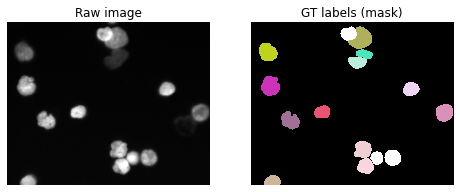

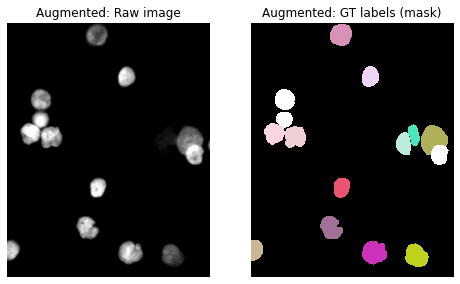

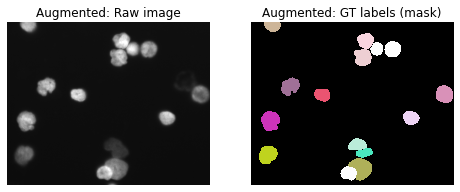

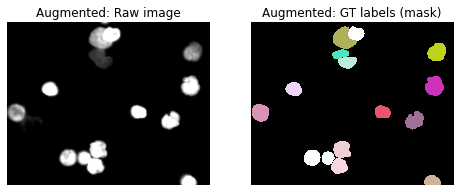

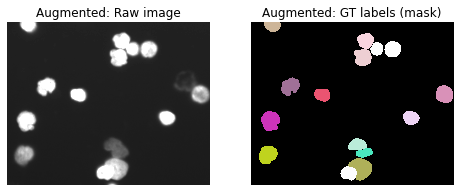

In [25]:
plt.figure(figsize=(8,5))
plt.subplot(121); plt.imshow(img,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
  
for _ in range(4):
    plt.figure(figsize=(8,5))
    x,y = augmenter(img, lbl)
    plt.subplot(121); plt.imshow(x,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Augmented: Raw image')
    plt.subplot(122); plt.imshow(y,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('Augmented: GT labels (mask)')
None;

# Model Training

In [26]:
%reload_ext tensorboard
%tensorboard --logdir=. --port 6008

Reusing TensorBoard on port 6008 (pid 4807), started 0:55:43 ago. (Use '!kill 4807' to kill it.)

In [27]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=40, steps_per_epoch=25)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained("2D_versatile_fluo")
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=100)
None;

Epoch 1/100
100/100 [==============================] - 22s 218ms/step - loss: 7.0864 - prob_loss: 0.5864 - dist_loss: 32.4999 - prob_kld: 0.4415 - dist_relevant_mae: 32.4985 - dist_relevant_mse: 1993.2085 - val_loss: 5.6221 - val_prob_loss: 0.4400 - val_dist_loss: 25.9103 - val_prob_kld: 0.3192 - val_dist_relevant_mae: 25.9069 - val_dist_relevant_mse: 1033.8584 - lr: 3.0000e-04
Epoch 2/100
100/100 [==============================] - 20s 195ms/step - loss: 5.5389 - prob_loss: 0.4896 - dist_loss: 25.2461 - prob_kld: 0.3359 - dist_relevant_mae: 25.2437 - dist_relevant_mse: 1292.5032 - val_loss: 4.3155 - val_prob_loss: 0.3760 - val_dist_loss: 19.6977 - val_prob_kld: 0.2551 - val_dist_relevant_mae: 19.6954 - val_dist_relevant_mse: 806.3408 - lr: 3.0000e-04
Epoch 3/100
100/100 [==============================] - 20s 198ms/step - loss: 4.6298 - prob_loss: 0.4999 - dist_loss: 20.6496 - prob_kld: 0.3499 - dist_relevant_mae: 20.6475 - dist_relevant_mse: 908.4773 - val_loss: 4.0861 - val_prob_loss:

# Threshold Optimization

In [28]:
if not quick_demo:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:43<00:10,  2.69s/it, 0.491 -> 0.765]


Using optimized values: prob_thresh=0.48987, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Prediction

In [29]:
DATASET_DIR = '../S-BSST265/'
DATASET_LIST_VAL = 'val.txt'
image_dir = os.path.join(DATASET_DIR, 'rawimages')
mask_dir = os.path.join(DATASET_DIR, 'groundtruth')

data_lines_val = open(os.path.join(DATASET_DIR, DATASET_LIST_VAL), 'r').readlines()
imagelist_val = list(map(lambda x: os.path.join(image_dir, x.strip()), data_lines_val))
masklist_val = list(map(lambda x: os.path.join(mask_dir, x.strip()), data_lines_val))

In [30]:
imagelist_val

['../S-BSST265/rawimages/Ganglioneuroblastoma_0.tif',
 '../S-BSST265/rawimages/Ganglioneuroblastoma_9.tif',
 '../S-BSST265/rawimages/Neuroblastoma_2.tif',
 '../S-BSST265/rawimages/Neuroblastoma_9.tif',
 '../S-BSST265/rawimages/normal_1.tif',
 '../S-BSST265/rawimages/normal_9.tif',
 '../S-BSST265/rawimages/normal_39.tif',
 '../S-BSST265/rawimages/otherspecimen_0.tif',
 '../S-BSST265/rawimages/otherspecimen_9.tif']

In [31]:
fXt = imagelist_val
fYt = masklist_val
print(f"{len(fXt)} files found")
Xt = list(map(read_tif,map(str,tqdm(fXt))))
Yt = list(map(read_tif,map(str,tqdm(fYt))))

n_channel = 1 if Xt[0].ndim == 2 else Xt[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

100%|██████████| 9/9 [00:00<00:00, 140.02it/s]

9 files found


keeping 277/5699 polygons
NMS took 0.0748 s


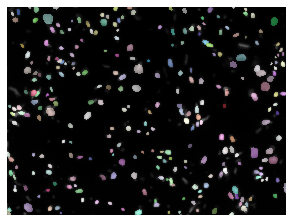

In [32]:
img = normalize(Xt[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, verbose = True)
plt.figure(figsize=(5,5))
plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, interpolation="nearest", alpha=0.5)
plt.axis('off');

## Utility for Showing Examples

In [33]:
def example(model, i, show_dist=True):
    img = normalize(Xt[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,:3]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, interpolation="nearest", alpha=0.5)
    plt.tight_layout()
    plt.show()

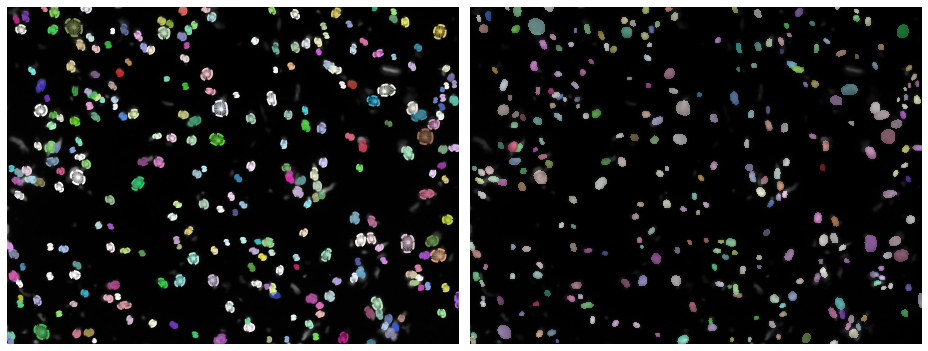

In [49]:
example(model,0)

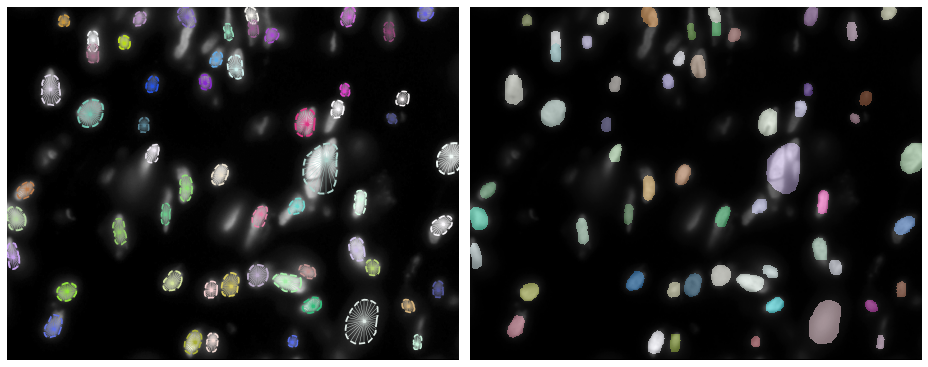

In [35]:
example(model,1)

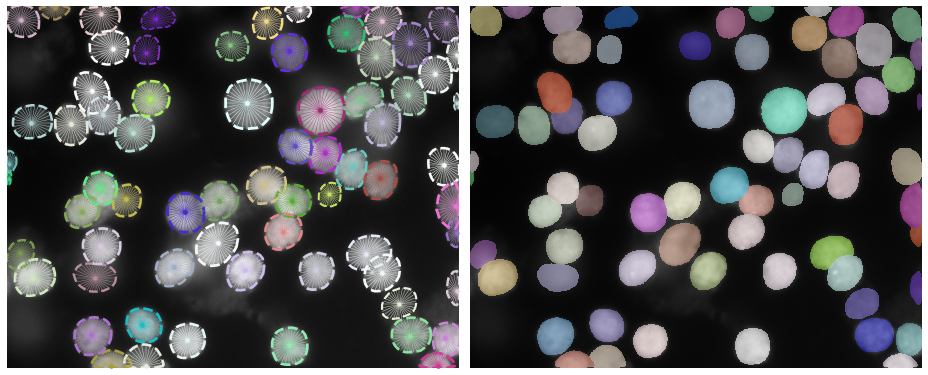

In [36]:
example(model,2)

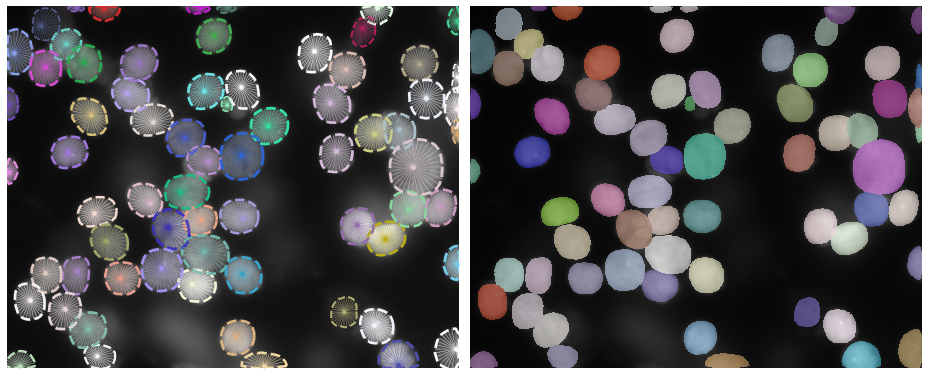

In [37]:
example(model,3)

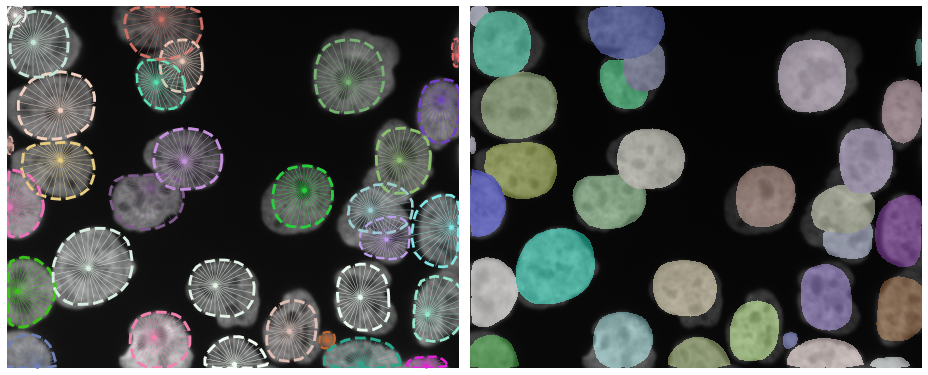

In [38]:
example(model,4)

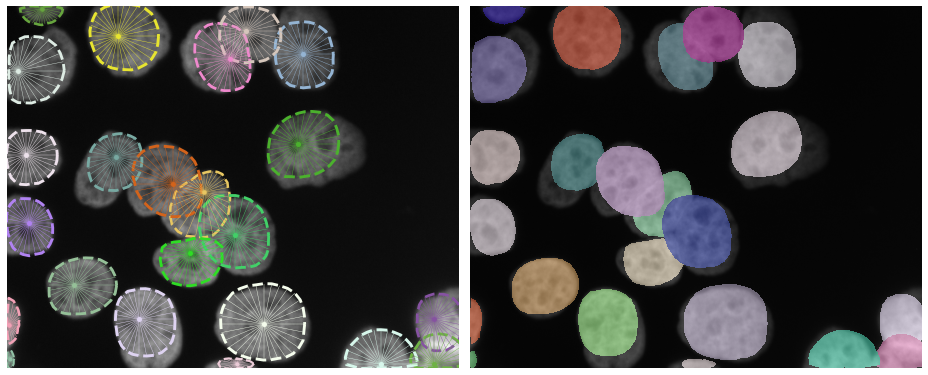

In [39]:
example(model,5)

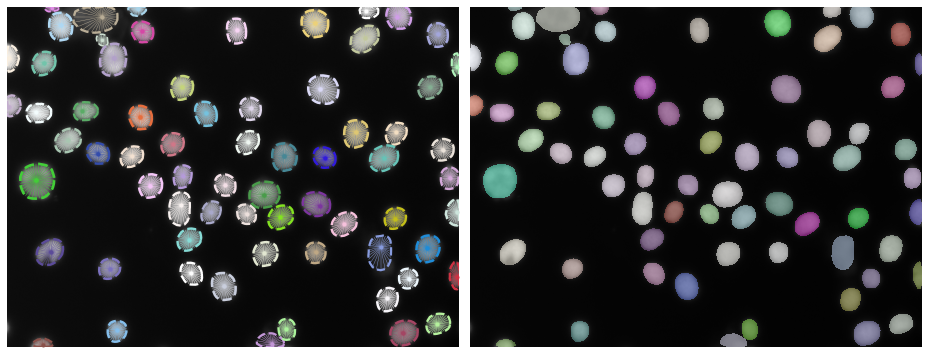

In [40]:
example(model,6)

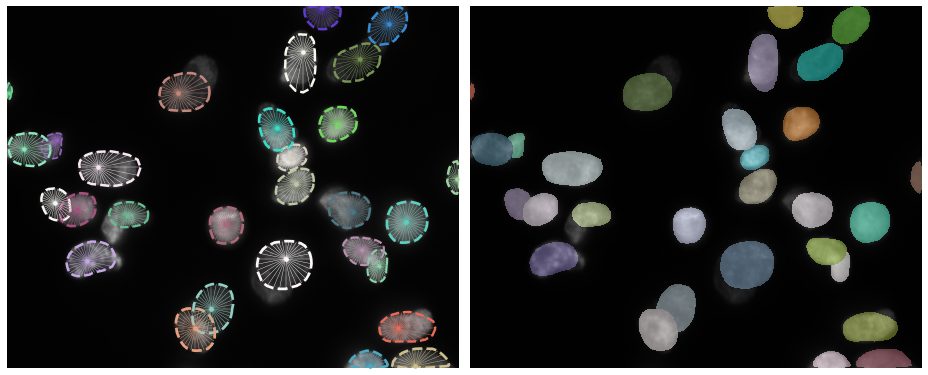

In [41]:
example(model,7)

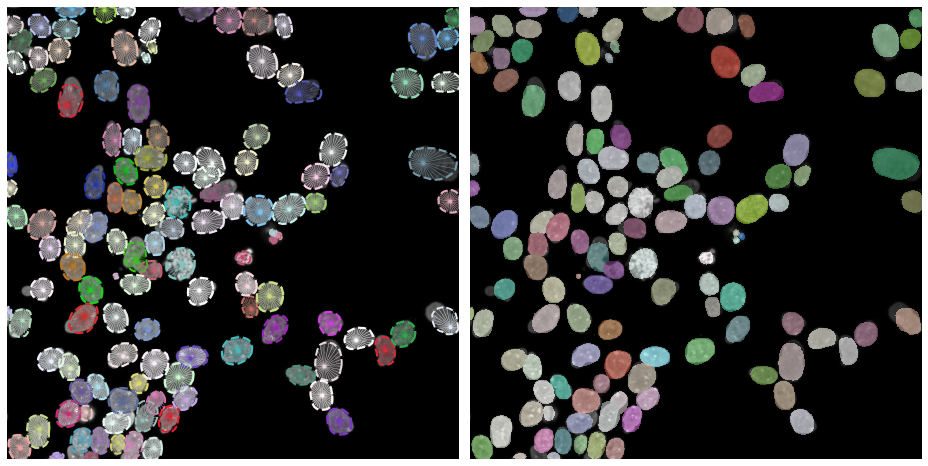

In [42]:
example(model,8)

# Evaluate Model

In [51]:
Yt_pred = [model.predict_instances(normalize(x, 1,99.8, axis=axis_norm), n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0] for x in tqdm(Xt)]

100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


In [53]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Yt, Yt_pred, thresh=t, show_progress=False) for t in tqdm(taus)]


100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


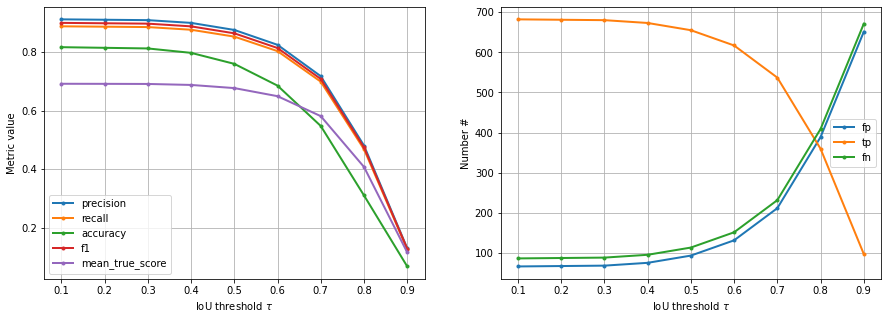

In [54]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [55]:
stats

[DatasetMatching(criterion='iou', thresh=0.1, fp=67, tp=682, fn=87, precision=0.910547396528705, recall=0.8868660598179454, accuracy=0.8157894736842105, f1=0.8985507246376812, n_true=769, n_pred=749, mean_true_score=0.691157903879597, mean_matched_score=0.7793261408847655, panoptic_quality=0.7002640686210936, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.2, fp=68, tp=681, fn=88, precision=0.9092122830440588, recall=0.8855656697009102, accuracy=0.8136200716845878, f1=0.8972332015810277, n_true=769, n_pred=749, mean_true_score=0.6909294875286047, mean_matched_score=0.7802125931123304, panoptic_quality=0.7000326428320118, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.3, fp=69, tp=680, fn=89, precision=0.9078771695594126, recall=0.8842652795838751, accuracy=0.8114558472553699, f1=0.8959156785243741, n_true=769, n_pred=749, mean_true_score=0.6905441867531869, mean_matched_score=0.7809242347252952, panoptic_quality=0.6996422656300405, by_image=False),
 DatasetMatc